# Wrangle and Analyze Data: WeRateDogs

## Project Outline:

**1. Data wrangling:**
- Gathering data
- Assessing data
- Cleaning data

**2. Storing, analyzing, and visualizing your wrangled data**

**3. Reporting**

## Introduction:

In this project, we are going to gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it anf finally act on it through analysis, visualization and/or modeling using Python (and its libraries) and/or SQL.

The dataset that we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user **@dog_rates**, also known as **WeRateDogs**. 

**WeRateDogs** is a **Twitter account** that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

The **Twitter archive** of WeRateDogs contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017. Of the 5000+ tweets, we have filtered for tweets with ratings only because not all 5000+ tweets are dog ratings and some are retweets. So there are about 2356 tweets.

The data was extracted programmatically from each tweet's text, but the ratings as well as dog names and dog stages probably aren't all correct. So, we'll need to assess and clean these columns in order to use them for analysis and visualization.
There is also additional data, which include retweet count and favorite count, can be also gathered programmatically from **Twitter's API** using **Tweepy Library in Python**

After having ran every image in the **WeRateDogs Twitter archive** through a **neural network** that can classify breeds of dogs, the output is a table full of **image predictions** (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

Our next step is that all of this additional data will need to be gathered, assessed, and cleaned.

## Step 1. Gathering Data:

The first step in our data wrangling process is gathering data from several different sources and file formats such as: 
- The WeRateDogs Twitter Archive, which is a cvs file that contains the tweet for each dog's name, its rating and stage.
- The Tweet Image Prediction, which is what breed of dog is in each tweet according to a neural network.
- The Twitter's API and JSON data, which will be used to gather retweet count and favorite count ( two missing columns in the Twitter Archive).  

In [116]:
#Import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import os
import tweepy
import json 
import time
import datetime

### 1. The WeRateDogs Twitter Archive:

In [117]:
# Display WeRateDogs Twitter Archive
twitter_arch = pd.read_csv('C:\\Users\\Pattu\\OneDrive\\Documents\\06. Udacity.Data Analyst\\03. Data Wrangling\\05. Wrangle and Analyze Data\\twitter-archive-enhanced-2.csv')
twitter_arch.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [118]:
twitter_arch.shape

(2356, 17)

The columns headers of the dataset are:
- **tweet_id** which is the unique identifier for each tweet
- **timestamp** which is the time when this Tweet was created
- **source** takes the form of an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client
- **text** is the actual UTF-8 text of the status update
- **rating_numerator** is the numerator of the rating of a dog which should be always greater than 10
- **rating_denominator** is the denominator of the rating of a dog which should be always a multiple of 10
- **name** is the name of the dog
- The four **dog stages** are **doggo**, **floofer**, **pupper**, and **puppo**

As already mentioned in the introduction, there are about 2356 tweets which represents the name of dogs, their breeds and also their ratings, etc.

### 2. The Tweet Image Prediction:

After having imported correctly the WeRateDogs Twitter Archive file into our DataFrame, we are going use **Web Scraping** to extract programmatically the **Tweet Image Prediction** which is hosted on Udacity's servers by using the **Requests and OS library** and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

The tweet image predictions represents what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. 

In [119]:
# Download the Tweet image prediction file 
file_name = 'image-predictions.tsv'

if not os.path.isfile(file_name): 
    url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
    response = requests.get(url)    

In [120]:
# Save the url to the Tweet image prediction file 
if not os.path.isfile(file_name):
    with open(file_name, mode='wb') as file:
        file.write(response.content)

In [121]:
# Display the Tweet Image Prediction
image_pred = pd.read_csv('C:\\Users\\Pattu\\OneDrive\\Documents\\06. Udacity.Data Analyst\\03. Data Wrangling\\05. Wrangle and Analyze Data\\image-predictions-3.tsv' , sep='\t')
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [122]:
image_pred.shape

(2075, 12)

The columns headers of the dataset are:
- **tweet_id** is the unique identifier for each tweet
- **jpg_url** is dog's image URL
- **img_num** is the image number that corresponded to the most confident prediction which is numbered from 1 to 4 since tweets can have up to 4 images
- **p1** is the algorithm's #1 prediction for the image in the tweet
- **p1_conf** refers to how confident the algorithm is in its #1 prediction
- **p1_dog** refers to whether or not the #1 prediction is a breed of dog
- **p2** is the algorithm's #2 prediction for the image in the tweet
- **p2_conf** represents to how confident the algorithm is in its #2 prediction
- **p2_dog** refers to whether or not the #2 prediction is a breed of dog
- **p3** is the algorithm's #3 prediction for the image in the tweet
- **p3_conf** refers to how confident the algorithm is in its #3 prediction
- **p3_dog** is whether or not the #3 prediction is a breed of dog

### 3. The Twitter's API and JSON:

Next, we are going to use **Twitter API** to import tweets into our DataFrame.

As each tweet's retweet count and favorite ("like") count at minimum, we are going to use the **tweet IDs** in the WeRateDogs Twitter archive, and then **query the Twitter API** for each **tweet's JSON data** using **Python's Tweepy library** and finally **store each tweet's entire set of JSON data** in a file called **tweet_json.txt file**. 

The Twitter API is one that requires users to be authorized to use it. This means that before we can run your API querying code, you need to set up our own Twitter application. Once we have our Twitter account and Twitter app set up, the following code, which is provided in the Getting started portion of the Tweepy documentation, will create an API object that we can use to gather Twitter data.

In [134]:
consumer_key = '3DO12k1XgcJUPxKEOzlcqjShD'
consumer_secret = 'IRcYj4r4afEKfjmiP1bUe5dvFcoLxP95gBoUlqXt1H3kLfFN0E'
access_token = '70109805-BHXEl0aoKplnweoCzYI1FgzeOkvo5KEHqRL5tURwm'
access_secret = 'dTjLY8YZzDOrBQ0H5huilcqMGNLmBUmDhhlCO8nsNka3w'

In [135]:
# Query the Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

Then in this code block we have to isolate the json part of each tweepy status object that we have downloaded and we add them all into a list called: my_list_of_dicts and then we write this list into a txt file: tweet_json.txt. The next step is to create a DataFrame from the tweet_json.txt file:

In [136]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
list_of_tweets = []
missing_tweets = [] # list of the tweets that can't be found are saved in the list

start_time = time.time() # calculate the time of execution

with open ('tweet_json.txt', 'a') as file:
    for tweet_id in twitter_arch['tweet_id']:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            list_of_tweets.append(tweet)   
            print("Success"),
            # writes one tweet per line
            file.write(json.dumps(tweet) + '\n')
            end_time = time.time()
            print('ID {} . Time in seconds: {}'.format(tweet_id, end_time-start_time))
        except Exception as e_message:
            missing_tweets.append(tweet_id)
            print("Error for ID: " + str(tweet_id) + str(e_message))
print('End reached.')

1: 892420643555336193
Success
ID 892420643555336193 . Time in seconds: 0.4091050624847412
2: 892177421306343426
Success
ID 892177421306343426 . Time in seconds: 0.6293797492980957
3: 891815181378084864
Success
ID 891815181378084864 . Time in seconds: 0.8389756679534912
4: 891689557279858688
Success
ID 891689557279858688 . Time in seconds: 1.0563342571258545
5: 891327558926688256
Success
ID 891327558926688256 . Time in seconds: 1.2554497718811035
6: 891087950875897856
Success
ID 891087950875897856 . Time in seconds: 1.473067045211792
7: 890971913173991426
Success
ID 890971913173991426 . Time in seconds: 1.6961610317230225
8: 890729181411237888
Success
ID 890729181411237888 . Time in seconds: 1.9164173603057861
9: 890609185150312448
Success
ID 890609185150312448 . Time in seconds: 2.117938280105591
10: 890240255349198849
Success
ID 890240255349198849 . Time in seconds: 2.324890613555908
11: 890006608113172480
Success
ID 890006608113172480 . Time in seconds: 2.522804021835327
12: 88988089

Rate limit reached. Sleeping for: 662



ID 758828659922702336 . Time in seconds: 238.60017490386963
901: 758740312047005698
Success
ID 758740312047005698 . Time in seconds: 905.895566701889
902: 758474966123810816
Success
ID 758474966123810816 . Time in seconds: 906.1867969036102
903: 758467244762497024
Success
ID 758467244762497024 . Time in seconds: 907.4350502490997
904: 758405701903519748
Success
ID 758405701903519748 . Time in seconds: 907.7516694068909
905: 758355060040593408
Success
ID 758355060040593408 . Time in seconds: 908.0034317970276
906: 758099635764359168
Success
ID 758099635764359168 . Time in seconds: 908.3150753974915
907: 758041019896193024
Success
ID 758041019896193024 . Time in seconds: 908.5554738044739
908: 757741869644341248
Success
ID 757741869644341248 . Time in seconds: 908.8101525306702
909: 757729163776290825
Success
ID 757729163776290825 . Time in seconds: 909.0556738376617
910: 757725642876129280
Success
ID 757725642876129280 . Time in seconds: 909.2840836048126
911: 757611664640446465
Succes

Rate limit reached. Sleeping for: 651


Success
ID 677187300187611136 . Time in seconds: 1154.318761587143
1801: 676975532580409345
Success
ID 676975532580409345 . Time in seconds: 1810.5876133441925
1802: 676957860086095872
Success
ID 676957860086095872 . Time in seconds: 1810.821872472763
1803: 676949632774234114
Success
ID 676949632774234114 . Time in seconds: 1811.0599761009216
1804: 676948236477857792
Success
ID 676948236477857792 . Time in seconds: 1811.3041019439697
1805: 676946864479084545
Success
ID 676946864479084545 . Time in seconds: 1811.656037569046
1806: 676942428000112642
Success
ID 676942428000112642 . Time in seconds: 1812.1482446193695
1807: 676936541936185344
Success
ID 676936541936185344 . Time in seconds: 1812.5812938213348
1808: 676916996760600576
Success
ID 676916996760600576 . Time in seconds: 1813.026374578476
1809: 676897532954456065
Success
ID 676897532954456065 . Time in seconds: 1813.5524730682373
1810: 676864501615042560
Success
ID 676864501615042560 . Time in seconds: 1813.984204530716
1811: 6

In [145]:
print("The list of tweets", len(list_of_tweets))
print("The list of missing tweets", len(missing_tweets))

The list of tweets 2331
The list of missing tweets 25


In [146]:
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [147]:
my_demo_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        created_at = each_dictionary['created_at']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'url': url,
                             'created_at': created_at,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite_count', 
                                                       'retweet_count', 'created_at',
                                                       'source', 'retweeted_status', 'url'])

In [148]:
# Change the name of the id column to tweet_id
tweet_json = tweet_json.rename(columns = {'id': 'tweet_id'})
tweet_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35006,7350,8973868,16,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30321,5480,8973868,16,Twitter for iPhone,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,22801,3624,8973868,16,Twitter for iPhone,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,38275,7535,8973868,16,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36551,8120,8973868,16,Twitter for iPhone,Original tweet,https://t.co/AtUZn91f7f


In [149]:
# Save the dataFrame in file
tweet_json.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [150]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   favorite_count    2331 non-null   int64 
 2   retweet_count     2331 non-null   int64 
 3   followers_count   2331 non-null   int64 
 4   friends_count     2331 non-null   int64 
 5   source            2331 non-null   object
 6   retweeted_status  2331 non-null   object
 7   url               2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


- **id** refers to the unique identifier for each tweet
- **retweet_count** is the number of times this Tweet has been retweeted
- **favorite_count** indicates approximately how many times this Tweet has been liked by Twitter users

Note that each tweet's entire set of JSON data is stored in **tweet_json.txt** file, and also each tweet's JSON data is written to its own line and the **tweet_json.txt** file is read line by line into a pandas DataFrame.

After having gathered data from **twitter-archive-enhanced.csv**, and downloading **image-predictions.tsv** from internet unsing requests library and then querying an API **tweet_json.txt** using Tweepy library, we are going to start the next step in our data wrangling process which is **Assessing Data**.

## Step 2. Assessing Data:

After gathering the data, the three tables which are **twitter_archive**, **image_prediction** and **tweet_json** were saved and assessed Visually and Programmatically to identify data quality issues.

### 1. Visual assessment:

In [151]:
# Display first 5 rows of the dataframe
twitter_arch.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [152]:
# Display last 5 rows of the dataframe
twitter_arch.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [153]:
# Display the image prediction table
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [154]:
# Display the tweet data table
tweet_data.head()

,tweet_id,retweet_count,favorite_count


Through Visual Assessment, we conclude that:
- There are some quality issues such as NaN and missing values in the twitter_archive table, while in the image prediction table there are some dogs' name in lowercase and others in uppercase. 
- The column text had multiple variables like a url link, rating, and some tweets represented two dogs.
- The tweet_count and archive table should be merged as this is related data.
- There are also non-descriptive column headers and duplicates that should be documented and then cleaned.

### 2. Programmatic assessment:

#### 2.1 Twitter Archive DataFrame:

In [155]:
# View a sample of data
twitter_arch.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2202,668643542311546881,NaN,NaN,2015-11-23 04:13:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Fascinating dog here. Loves beach. Oddly long ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668643542...,3,10,None,None,None,None,None
2030,671789708968640512,NaN,NaN,2015-12-01 20:35:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is space pup. He's very confused. Tries t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671789708...,13,10,space,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
1998,672538107540070400,NaN,NaN,2015-12-03 22:09:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Darby. He's a Fiscal Tutankhamen Waxbeard...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672538107...,7,10,Darby,None,None,None,None
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916...,6,10,None,None,None,None,None


In [156]:
# View info of twitter_archive DataFrame
twitter_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

- tweet_id should be object instead of dtype int64 
- timestamp should be a datetime64 dtype type as well
- dogs' stage (doggo, floofer, pupper, and puppo) should be merged into one column

In [157]:
# View descriptive statistics of twitter_archive DataFrame
twitter_arch[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


Note that the minimum of both rating_numerator and rating_denominator is zero, while the maximum of rating respectively is 1,776 and 170.

As WeRateDogs has ratings almost always have a denominator of 10 and the numerators almost always greater than 10. 11/10, 12/10, 13/10, etc, we are going to check which numerator has a rating less than 10 as well as which denominator has a value of 0.

In [158]:
# Count the number of rating_numerator less than 10
twitter_arch[twitter_arch['rating_numerator'] < 10].count()[0]

440

In [159]:
# Check which tweet_id have numerator less than 10
twitter_arch[twitter_arch['rating_numerator'] < 10].tweet_id

45      883482846933004288
229     848212111729840128
315     835152434251116546
387     826598799820865537
462     817502432452313088
               ...        
2351    666049248165822465
2352    666044226329800704
2353    666033412701032449
2354    666029285002620928
2355    666020888022790149
Name: tweet_id, Length: 440, dtype: int64

In [160]:
# Check which tweet_id have denominator with zero value
twitter_arch[twitter_arch['rating_denominator'] == 0].tweet_id

313    835246439529840640
Name: tweet_id, dtype: int64

In [161]:
# Check their respective text
twitter_arch.loc[313, 'text']

"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"

In [162]:
sum(twitter_arch.rating_denominator != 10)

23

In [163]:
sum(twitter_arch['tweet_id'].duplicated())

0

In [164]:
# Check for missing values
twitter_arch.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [165]:
# View number of entries for each source
twitter_arch['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

The source column looks messy:
- There are two variables in one column which violates the "each variable forms a column" requirement. There is "href" and also "rel" which should be split into 2 separate columns.
- The main source of twitter is iphone but the urls are not readable for human.

In [166]:
twitter_arch['text'].value_counts()

If you are aware of who is making these please let me know. 13/10 vroom vroom https://t.co/U0D1sbIDrG                                               1
12/10 gimme now https://t.co/QZAnwgnOMB                                                                                                             1
Downright majestic af 12/10 https://t.co/WFh2FEbYzj                                                                                                 1
Just got home from college. Dis my dog. She does all my homework. Big red turd in background. 13/10 no bias at all https://t.co/6WGFp9cuj6          1
This is Ruby. She just turned on the news. Officially terrified. 11/10 deep breaths Ruby https://t.co/y5KarNXWXt                                    1
                                                                                                                                                   ..
Say hello to Sadie. She's a Tortellini Sidewinder. Very jubilant pup. Seems loyal. Leaves on point. 

In [169]:
# Check missing information for each dog stages
doggo = twitter_arch.doggo.value_counts()
floofer = twitter_arch.floofer.value_counts()
pupper = twitter_arch.pupper.value_counts()
puppo = twitter_arch.puppo.value_counts()
print(doggo); print(floofer); print(pupper); print(puppo);

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


There are missing information for each dog stages.

In [170]:
twitter_arch.name.value_counts().head(20)

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
Lucy        11
Lola        10
Tucker      10
Penny       10
Winston      9
Bo           9
the          8
Sadie        8
Bailey       7
Buddy        7
an           7
Toby         7
Daisy        7
Oscar        6
Stanley      6
Name: name, dtype: int64

"None" means that there are many missing names from the list, While "a", "Bo" and "an" might be the first letter of random names. 

#### 2.2 Image Prediction DataFrame:

In [171]:
# View a sample of image_predictions DataFrame
image_pred.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
995,708149363256774660,https://pbs.twimg.com/media/CdPaEkHW8AA-Wom.jpg,1,Cardigan,0.350993,True,basset,0.164555,True,toy_terrier,0.080484,True
158,668872652652679168,https://pbs.twimg.com/media/CUhQIAhXAAA2j7u.jpg,1,teddy,0.413379,False,pillow,0.325623,False,miniature_schnauzer,0.035537,True
2010,878776093423087618,https://pbs.twimg.com/media/DDIKMXzW0AEibje.jpg,2,Italian_greyhound,0.734684,True,whippet,0.150487,True,Ibizan_hound,0.039725,True
593,679475951516934144,https://pbs.twimg.com/media/CW37xZbUoAAUXe5.jpg,1,Maltese_dog,0.145742,True,toy_poodle,0.139407,True,West_Highland_white_terrier,0.108821,True
190,669393256313184256,https://pbs.twimg.com/media/CUopnHPVEAAcL2o.jpg,1,cocker_spaniel,0.359843,True,Blenheim_spaniel,0.139519,True,toy_poodle,0.132746,True


Note that the dog breed name values in the p1, p2, and p3 columns are not consistantly stored. Some name are either in lowercase or in uppercase while others have wrong name such Siamese cat, bathtub, or hamster. Some dog breed name have underscores with should be replaced with spaces for better readability.

In [172]:
# Check if the tweet_id 740676976021798912 is for a Siamese cat
image_pred.loc[1197, 'jpg_url']

'https://pbs.twimg.com/media/Ckdpx5KWsAANF6b.jpg'

In [173]:
# Check out how to get Jupyter Notebook to show images
from IPython.display import Image 
Image(url = 'https://pbs.twimg.com/media/Ckdpx5KWsAANF6b.jpg') 

This is definitely a dog not a Siamese cat.

In [174]:
# view the dimension of the dataset
image_pred.shape

(2075, 12)

In [175]:
# Display a basic summary of the DataFrame
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- There are no missing values as all variables have 2075 records.
- The tweet_id column should be object as dtype instead of int64.

In [176]:
# View descriptive statistics of image_predictions DataFrame
image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [177]:
# check for duplicates
sum(image_pred.jpg_url.duplicated())

66

In [178]:
sum(image_pred['tweet_id'].value_counts())

2075

In [179]:
image_pred['img_num'].value_counts() 

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

#### 2.3 Tweet JSON DataFrame:

In [183]:
tweet_json.sample(5)

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
1296,706346369204748288,3321,884,8973893,16,Twitter for iPhone,Original tweet,https://t.co/VZV6oMJmU6
14,889531135344209921,13812,1968,8973868,16,Twitter for iPhone,Original tweet,https://t.co/y70o6h3isq
1186,715680795826982913,4111,1522,8973893,16,Twitter for iPhone,Original tweet,https://t.co/sSugyyRuTp
1959,672902681409806336,1281,455,8973906,16,Twitter for iPhone,Original tweet,https://t.co/KpLyca3o3E
1630,683449695444799489,3722,1535,8973894,16,Twitter for iPhone,Original tweet,https://t.co/1Z7Q6svWpe


In [184]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   favorite_count    2331 non-null   int64 
 2   retweet_count     2331 non-null   int64 
 3   followers_count   2331 non-null   int64 
 4   friends_count     2331 non-null   int64 
 5   source            2331 non-null   object
 6   retweeted_status  2331 non-null   object
 7   url               2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


- There are no missing values as all variables have 16709 entries.

In [185]:
# display statistic basic summary 
tweet_json.describe()

,favorite_count,retweet_count,followers_count,friends_count
count,2331.000000,2331.000000,2.331000e+03,2331.0
mean,7309.758044,2586.980266,8.973894e+06,16.0
std,11353.248199,4376.020922,5.636278e+01,0.0
min,0.000000,1.000000,8.973867e+06,16.0
25%,1267.000000,524.500000,8.973872e+06,16.0
50%,3171.000000,1206.000000,8.973893e+06,16.0
75%,8935.500000,2994.500000,8.973894e+06,16.0
max,150469.000000,74245.000000,8.974446e+06,16.0


Taking a look at the describe output for the "tweet_data" table, we conclude that there is a gap of 5,746 between 25% and 50% while it is much bigger of 7,972 between 50% and 75% which suggests that there is a **massive skew** in the distribution.

In [186]:
# check for missing values
tweet_json.isnull().sum()

tweet_id            0
favorite_count      0
retweet_count       0
followers_count     0
friends_count       0
source              0
retweeted_status    0
url                 0
dtype: int64

Duplicate column names can be found more generally in Pandas, using the following code:

In [188]:
all_columns = pd.Series(list(twitter_arch) + list(image_pred) + list(tweet_json))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
34      source
dtype: object

### Quality Issues:

**Twitter Archive Table:**
- Q 1: There are 181 retweets as indicated by retweeted status id
- Q 2: Missing values in columns: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id, in_reply_to_user_id.
- Q 3: tweet_id should be object instead of dtype int64
- Q 4: timestamp should be a datetime64 dtype type
- Q 5: Invalide dog names: "None", "a", "an", etc
- Q 6: Innacurate ratings: The number of rating numerator less than 10 are 440; 23 rating denominators are not equal to 10; and the tweet_id 835246439529840640 has a rating denominator with zero value. In addition, some ratings with decimals have been incorrectly exported.
- Q 7: There are two variables in one column which violates the "each variable forms a column" requirement. There is "href" and also "rel" which should mention only the main source of both of them.

**Image Prediction Table:**
- Q 3: tweet_id should be object instead of dtype int64
- Q 8: Dog breed name values in the p1, p2, and p3 had some uppercase and lowercase letters.
- Q 9: Multiple columns containing the same type of data in the predictions table.
- Q 10:There are 66 jpg_url duplicates Image Predictions Table

**Tweet JASON Table:**
- Q 3: tweet_id should be object instead of dtype int64
- Q 11: There are duplicates in tweet_id in tweet_data_clean Table.

### Tidiness issues:

- T 1: Dog stage data is separated into 4 columns (doggo, floofer, pupper, and puppo) which should be merged in one column
- T 2: Some additional work on our new DataFrame should be done for better redability and before merging the 3 tables
- T 3: All 3 tables are related by a commun key "tweet_id" and shouldn't be divided into separate DataFrame

## Step 3. Cleaning Data:

Cleaning data is the third step in data wrangling process. We are going to fix the quality and tidiness issues that we have identified in the assess step.

In [1004]:
# Create DataFrame copies
twitter_arch_clean = twitter_arch.copy()
image_pred_clean = image_pred.copy()
tweet_json_clean = tweet_json.copy()

In [1005]:
twitter_arch_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


In [1006]:
image_pred_clean.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [1007]:
tweet_json_clean.head(1)

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35006,7350,8973868,16,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU


In [1008]:
print(twitter_arch_clean.shape)
print(image_pred_clean.shape)
print(tweet_json_clean.shape)

(2356, 17)
(2075, 12)
(2331, 8)


### 1. Cleaning for Quality:

Programmatic data cleaning as its own separate process within data wrangling has 3 steps: **defining**, **coding** and **testing**. First of all, we'll define cleaning data plan in writing, then we'll translate it into code, and finally, we'll test the dataset often using code to make sure the cleaning code worked.

**Q 1:** There are 181 retweets as indicated by retweeted status id<br>
**Define:**  Remove all retweets from table  and keep only original tweets<br>
**Code:**

In [1009]:
# Remove from table retweets and keep only original tweets
twitter_arch_clean = twitter_arch_clean[twitter_arch_clean.retweeted_status_id.isnull()]
twitter_arch_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


**Test:**

In [1010]:
# Check no non-null entires are left
twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

**Q 2:** Missing values in columns: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id, in_reply_to_user_id, expanded_urls.<br>
**Define:**  Remove columns that won't be used for analysis using drop() method<br>
**Code:**

In [1011]:
# Drop related columns
twitter_arch_clean = twitter_arch_clean.drop(columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp',
                                                        'in_reply_to_status_id', 'in_reply_to_user_id', 'in_reply_to_user_id', 'expanded_urls'])
twitter_arch_clean.head(1)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None


In [1012]:
twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   rating_numerator    2175 non-null   int64 
 5   rating_denominator  2175 non-null   int64 
 6   name                2175 non-null   object
 7   doggo               2175 non-null   object
 8   floofer             2175 non-null   object
 9   pupper              2175 non-null   object
 10  puppo               2175 non-null   object
dtypes: int64(3), object(8)
memory usage: 203.9+ KB


Once the missing data and tidiness issues are cleaned, the next step is cleaning the remaining data quality issues. So, we are going to use a variety of common pandas functions to clean them all.

**Q 3:**  tweet_id should be object instead of dtype int64 <br>
**Define:**   Convert tweet_id from an integer to to object using the astype() function for all DataFrame.<br>
**Code:**

In [1013]:
# Convert tweet_id from an integer to to object 
twitter_arch_clean['tweet_id'] = twitter_arch_clean['tweet_id'].astype('str')
image_pred_clean['tweet_id'] = image_pred_clean['tweet_id'].astype('str')
tweet_json_clean['tweet_id'] = tweet_json_clean['tweet_id'].astype('str')

**Test:**

In [1014]:
twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   object
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   rating_numerator    2175 non-null   int64 
 5   rating_denominator  2175 non-null   int64 
 6   name                2175 non-null   object
 7   doggo               2175 non-null   object
 8   floofer             2175 non-null   object
 9   pupper              2175 non-null   object
 10  puppo               2175 non-null   object
dtypes: int64(2), object(9)
memory usage: 203.9+ KB


In [1015]:
image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [1016]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   favorite_count    2331 non-null   int64 
 2   retweet_count     2331 non-null   int64 
 3   followers_count   2331 non-null   int64 
 4   friends_count     2331 non-null   int64 
 5   source            2331 non-null   object
 6   retweeted_status  2331 non-null   object
 7   url               2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


**Q 4:** timestamp should be a datetime64 dtype type <br>
**Define:** Convert Timestamps from object to datetime format using pandas to_datetime() function.<br>
**Code:**

In [1017]:
twitter_arch_clean['timestamp'] = pd.to_datetime(twitter_arch_clean['timestamp'])

In [1018]:
twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   int64              
 5   rating_denominator  2175 non-null   int64              
 6   name                2175 non-null   object             
 7   doggo               2175 non-null   object             
 8   floofer             2175 non-null   object             
 9   pupper              2175 non-null   object             
 10  puppo               2175 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(8)
memory usage: 203.9+ KB


**Q 5:** Invalide dog names: "None", "a", "an", etc <br>
**Define:**  Replace Invalide dog names with NaNs.<br>
**Code:**

In [1019]:
# Check the number of invalid dog names
twitter_arch_clean['name'].value_counts().head(10)

None       680
a          55 
Lucy       11 
Charlie    11 
Oliver     10 
Cooper     10 
Penny      9  
Tucker     9  
the        8  
Lola       8  
Name: name, dtype: int64

In [1020]:
# Convert invalide dog names with lower case letters to NaN
twitter_arch_clean = twitter_arch_clean.replace(regex = ['^[a-z]+', 'None'], value = np.nan)

**Test:**

In [1021]:
# Check the number of null values in "name" column after conversion
sum(twitter_arch_clean.name.isnull())

784

In [1022]:
twitter_arch_clean['name'].value_counts().head(10)

Charlie    11
Lucy       11
Cooper     10
Oliver     10
Tucker     9 
Penny      9 
Sadie      8 
Lola       8 
Winston    8 
Toby       7 
Name: name, dtype: int64

In [1023]:
twitter_arch_clean['name'].sample(10)

1984    Jimison
757     Penny  
2273    NaN    
417     Paisley
1806    NaN    
862     Leela  
1746    Louis  
737     Dash   
644     Newt   
1057    Edmund 
Name: name, dtype: object

**Q 6:** Innacurate numerators and denominators ratings: Some ratings with decimals have been incorrectly exported <br>
**Define:**  Find all ratings that contained decimals and replace the numerators with the correct values.<br>
**Code:**

In [1024]:
twitter_arch_clean = twitter_arch.copy()

In [1025]:
# Obtain all text, indices, and ratings for tweets that contain a decimal in the numerator of rating

import re

ratings_decimals_text = []
ratings_decimals_index = []
ratings_decimals = []

for i, text in twitter_arch_clean['text'].iteritems():
    if bool(re.search('\d+\.\d+\/\d+', text)):
        ratings_decimals_text.append(text)
        ratings_decimals_index.append(i)
        ratings_decimals.append(re.search('\d+\.\d+', text).group())

# Print the text to confirm presence of ratings with decimals          
ratings_decimals_text

['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
 "RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",
 "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
 "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
 "I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace",
 'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']

In [1026]:
# Print the index of text with decimal ratings
ratings_decimals_index

[45, 340, 695, 763, 1689, 1712]

In [1027]:
#Correctly converting the above decimal ratings to float
twitter_arch_clean.loc[ratings_decimals_index[0],'rating_numerator'] = float(ratings_decimals[0])
twitter_arch_clean.loc[ratings_decimals_index[1],'rating_numerator'] = float(ratings_decimals[1])
twitter_arch_clean.loc[ratings_decimals_index[2],'rating_numerator'] = float(ratings_decimals[2])
twitter_arch_clean.loc[ratings_decimals_index[3],'rating_numerator'] = float(ratings_decimals[3])
twitter_arch_clean.loc[ratings_decimals_index[4],'rating_numerator'] = float(ratings_decimals[4])

**Test:**

In [1028]:
# Check contents of row with index 45 
twitter_arch_clean.loc[45]

tweet_id                      883482846933004288                                                                                                                      
in_reply_to_status_id         NaN                                                                                                                                     
in_reply_to_user_id           NaN                                                                                                                                     
timestamp                     2017-07-08 00:28:19 +0000                                                                                                               
source                        <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>                                                      
text                          This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt94

In [1029]:
# Check if the tweet_id 883482846933004288 is for Bella
image_pred_clean.loc[45, 'jpg_url']

'https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg'

In [1030]:
from IPython.display import Image 
Image(url = ' https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg')

In [1031]:
# Create a new column called rating, and calulate the value with new, standardized ratings
twitter_arch_clean['rating'] = twitter_arch_clean['rating_numerator'] / twitter_arch_clean['rating_denominator']

In [1032]:
twitter_arch_clean.rating.head()

0    1.3
1    1.3
2    1.2
3    1.3
4    1.2
Name: rating, dtype: float64

In [1033]:
twitter_arch_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,None,None,None,None,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,None,None,None,None,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,None,None,None,None,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10,Darla,None,None,None,None,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10,Franklin,None,None,None,None,1.2


**Q 7:** There are two variables in one column which violates the "each variable forms a column" requirement. There is "href" and also "rel" which should be split into 2 separate columns.<br>
**Define:** Optimize the source content by "Twitter for iphone", "Vine - Make a Scene", "Twitter Web Client", and "TweetDeck".<br>
**Code:**    

In [1034]:
# Check how many sources
twitter_arch_clean['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [1035]:
# simpfy the source contexts
twitter_arch_clean['source'] = twitter_arch_clean['source'].replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iphone')
twitter_arch_clean['source'] = twitter_arch_clean['source'].replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine - Make a Scene')
twitter_arch_clean['source'] = twitter_arch_clean['source'].replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
twitter_arch_clean['source'] = twitter_arch_clean['source'].replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

**Test:**

In [1036]:
twitter_arch_clean['source'].value_counts()

Twitter for iphone     2221
Vine - Make a Scene    91  
Twitter Web Client     33  
TweetDeck              11  
Name: source, dtype: int64

**Q 8:** Dog breed name values in the p1, p2, and p3 had some uppercase and lowercase letters.<br>
**Define:** Capitalize the first letter of dog breed (p1, p2, and p3) for consistence.<br>
**Code:**      

In [1037]:
image_pred_clean = image_pred.copy()

In [1038]:
# View the number of dog breed name start with lowercase letters
image_pred_clean['p1'].str.islower().sum(), image_pred_clean['p1'].str.islower().sum(), image_pred_clean['p1'].str.islower().sum()

(1135, 1135, 1135)

In [1039]:
# Change the strings to uppercase
image_pred_clean['p1'] = image_pred_clean['p1'].str.capitalize()
image_pred_clean['p2'] = image_pred_clean['p2'].str.capitalize()
image_pred_clean['p3'] = image_pred_clean['p3'].str.capitalize()

**Test:**

In [1040]:
# Check for corrections
image_pred_clean['p1'].str.islower().sum()
image_pred_clean['p2'].str.islower().sum()
image_pred_clean['p3'].str.islower().sum()

0

In [1041]:
image_pred_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**Q 9:** Multiple columns of dog breed (p1, p2, and p3) containing the same type of data in the predictions table.<br>
**Define:** Create one column for dog_breed and another one for confidence_list. Then we have to create a function where we keep the first true prediction along the confidence level as new columns.<br>
**Code:**  

In [1042]:
# Create lists where the true prediction (p1, p2 or p3) will be stored in 
dog_breed = []
confidence_list = []

# Create a function with nested if to capture the dog type and confidence level
# from the first 'true' prediction
def image(image_pred_clean):
    if image_pred_clean['p1_dog'] == True:
        dog_breed.append(image_pred_clean['p1'])
        confidence_list.append(image_pred_clean['p1_conf'])
    elif image_pred_clean['p2_dog'] == True:
        dog_breed.append(image_pred_clean['p2'])
        confidence_list.append(image_pred_clean['p2_conf'])
    elif image_pred_clean['p3_dog'] == True:
        dog_breed.append(image_pred_clean['p3'])
        confidence_list.append(image_pred_clean['p3_conf'])
    else:
        dog_breed.append('Error')
        confidence_list.append('Error')

# Series objects having index the image_prediction_clean column.        
image_pred_clean.apply(image, axis=1)

# Create new columns
image_pred_clean['dog_breed'] = dog_breed
image_pred_clean['confidence_list'] = confidence_list

In [1043]:
# Drop rows that has prediction_list 'error'
image_pred_clean = image_pred_clean[image_pred_clean['dog_breed'] != 'Error']

# Delete columns that won't be used for analysis
image_pred_clean = image_pred_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 
                                                      'p3', 'p3_conf', 'p3_dog'], 1)

**Test:**

In [1044]:
# Check correction
image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         1751 non-null   int64 
 1   jpg_url          1751 non-null   object
 2   dog_breed        1751 non-null   object
 3   confidence_list  1751 non-null   object
dtypes: int64(1), object(3)
memory usage: 68.4+ KB


In [1045]:
image_pred_clean.head()

,tweet_id,jpg_url,dog_breed,confidence_list
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature_pinscher,0.560311


**Q 10:** There are 66 jpg_url duplicates in Image Predictions Table.<br>
**Define:** Drop 66 jpg_url duplicated.<br>
**Code:**  

In [1046]:
# Delete duplicated jpg_url
image_pred_clean = image_pred_clean.drop_duplicates(subset=['jpg_url'], keep='last')

**Test:**

In [1047]:
sum(image_pred_clean['jpg_url'].duplicated())

0

**Q 11:** There are duplicates in tweet_id in tweet_data_clean Table.<br>
**Define:** Drop the duplicates in tweet_id from tweet_data_clean.<br>
**Code:**  

In [1048]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   favorite_count    2331 non-null   int64 
 2   retweet_count     2331 non-null   int64 
 3   followers_count   2331 non-null   int64 
 4   friends_count     2331 non-null   int64 
 5   source            2331 non-null   object
 6   retweeted_status  2331 non-null   object
 7   url               2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


In [1049]:
tweet_json_clean['tweet_id'].shape

(2331,)

In [1050]:
# Check for duplicates in tweet_id 
sum(twitter_arch_clean.tweet_id.duplicated()), sum(image_pred_clean.tweet_id.duplicated()), sum(tweet_json_clean.tweet_id.duplicated())

(0, 0, 0)

In [1051]:
# drop the duplicates in tweet_id from tweet_data_clean
tweet_json_clean.drop_duplicates(subset = ['tweet_id'])

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35006,7350,8973868,16,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30321,5480,8973868,16,Twitter for iPhone,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,22801,3624,8973868,16,Twitter for iPhone,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,38275,7535,8973868,16,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36551,8120,8973868,16,Twitter for iPhone,Original tweet,https://t.co/AtUZn91f7f
...,...,...,...,...,...,...,...,...
2326,666049248165822465,93,38,8973909,16,Twitter for iPhone,Original tweet,https://t.co/4B7cOc1EDq
2327,666044226329800704,259,122,8973909,16,Twitter for iPhone,Original tweet,https://t.co/DWnyCjf2mx
2328,666033412701032449,107,39,8973909,16,Twitter for iPhone,Original tweet,https://t.co/y671yMhoiR
2329,666029285002620928,118,41,8973909,16,Twitter for iPhone,Original tweet,https://t.co/r7mOb2m0UI


In [1052]:
# confirm correction by rechecking for duplicates
sum(tweet_json_clean.duplicated())

0

In [1053]:
tweet_json_clean.isnull().sum()

tweet_id            0
favorite_count      0
retweet_count       0
followers_count     0
friends_count       0
source              0
retweeted_status    0
url                 0
dtype: int64

In [1054]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   favorite_count    2331 non-null   int64 
 2   retweet_count     2331 non-null   int64 
 3   followers_count   2331 non-null   int64 
 4   friends_count     2331 non-null   int64 
 5   source            2331 non-null   object
 6   retweeted_status  2331 non-null   object
 7   url               2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


### 2. Cleaning for Tidiness:

After addressing missing data and quality issues first, cleaning for tidiness is the next step. <br>

**T 1:** Dog stage data is separated into 4 columns which should be merged in one column<br>
**Define:**  Extract dog stage from text column into the new dog_stage using pandas.Series.str.cat to concatenate strings in the Series and merge the 4 columns into one column: **dog_stage** and then drop the unrequired columns <br>
**Code:**

In [1055]:
twitter_arch_clean[twitter_arch_clean['doggo'] == 'None'].head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,Twitter for iphone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,None,None,None,None,1.3


In [1056]:
# use a for loop to replace all the 'None' 
dog_stage = ['doggo','pupper', 'floofer', 'puppo' ]
for i in dog_stage:
        twitter_arch_clean[i] = twitter_arch_clean[i].replace('None', '')

In [1057]:
# use pandas.Series.str.cat to combine the 4 columns
twitter_arch_clean['dog_stage'] = twitter_arch_clean.doggo.str.cat(twitter_arch_clean.floofer).str.cat(twitter_arch_clean.pupper).str.cat(twitter_arch_clean.puppo)

In [1058]:
# Drop the unrequired columns
twitter_arch_clean = twitter_arch_clean.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

In [1059]:
# use np.nan to fill the empty
twitter_arch_clean['dog_stage'] = twitter_arch_clean['dog_stage'].replace('', np.nan)

In [1060]:
twitter_arch_clean.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,rating,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,Twitter for iphone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,1.3,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,Twitter for iphone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,1.3,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,Twitter for iphone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,1.2,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,Twitter for iphone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10,Darla,1.3,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,Twitter for iphone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10,Franklin,1.2,NaN


**Test:**

In [1061]:
twitter_arch_clean.dog_stage.value_counts()

pupper          245
doggo           83 
puppo           29 
doggopupper     12 
floofer         9  
doggopuppo      1  
doggofloofer    1  
Name: dog_stage, dtype: int64

**T 2:** Some additional work on our DataFrames should be done for better redability<br>
**Define:**  We have to set column width to infinite; then change the column names; and replace the underscores with spaces;  and finally reorder the column placement .<br> 
**Code:** 

In [1062]:
# Set column width to infinite so entire content of 'text' column is displayed
pd.set_option('display.max_colwidth', -1)

C:\Users\Pattu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [1063]:
twitter_arch_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,rating,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,Twitter for iphone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,1.3,NaN


In [1064]:
# Drop unecessary columns
twitter_arch_clean = twitter_arch_clean.drop(columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
                                         'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator'])
                                                                          
# Confirm correction
twitter_arch_clean.head(0)

,tweet_id,timestamp,source,text,name,rating,dog_stage


In [1065]:
# Remove underscores from dog breed
image_pred_clean['dog_breed'] = image_pred_clean['dog_breed'] .replace("_", " ", regex = True)
image_pred_clean['dog_breed'] = image_pred_clean['dog_breed'] .str.title()

# Confirm correction
image_pred_clean.breed.head()

AttributeError: 'DataFrame' object has no attribute 'breed'

In [1066]:
twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   2356 non-null   int64  
 1   timestamp  2356 non-null   object 
 2   source     2356 non-null   object 
 3   text       2356 non-null   object 
 4   name       2356 non-null   object 
 5   rating     2356 non-null   float64
 6   dog_stage  380 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 129.0+ KB


In [1067]:
# Convert tweet_id from an integer to to object 
twitter_arch_clean['tweet_id'] = twitter_arch_clean['tweet_id'].astype('str')
image_pred_clean['tweet_id'] = image_pred_clean['tweet_id'].astype('str')
tweet_json_clean['tweet_id'] = tweet_json_clean['tweet_id'].astype('str')

In [1068]:
twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   2356 non-null   object 
 1   timestamp  2356 non-null   object 
 2   source     2356 non-null   object 
 3   text       2356 non-null   object 
 4   name       2356 non-null   object 
 5   rating     2356 non-null   float64
 6   dog_stage  380 non-null    object 
dtypes: float64(1), object(6)
memory usage: 129.0+ KB


In [1069]:
image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         1691 non-null   object
 1   jpg_url          1691 non-null   object
 2   dog_breed        1691 non-null   object
 3   confidence_list  1691 non-null   object
dtypes: object(4)
memory usage: 66.1+ KB


In [1070]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   favorite_count    2331 non-null   int64 
 2   retweet_count     2331 non-null   int64 
 3   followers_count   2331 non-null   int64 
 4   friends_count     2331 non-null   int64 
 5   source            2331 non-null   object
 6   retweeted_status  2331 non-null   object
 7   url               2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


**T 3:** All 3 tables are related by a commun key "tweet_id" and shouldn't be divided into separate DataFrame<br>
**Define:**  Merge the twitter archive into the image predictions using Join Method, and merge the resulting DataFrame with Twitter JSON.<br>
**Code:** 

In [1071]:
# Create a new dataframe that merge all 3 tables
We_Rate_Dogs = pd.merge(twitter_arch_clean, image_pred_clean, how = 'left', on = ['tweet_id'])
We_Rate_Dogs = pd.merge(We_Rate_Dogs, tweet_json_clean, how = 'left', on = ['tweet_id'])

# drop the duplicates due to join
We_Rate_Dogs = We_Rate_Dogs.drop_duplicates()

**Test:**

In [1072]:
# Display the new DataFrame
We_Rate_Dogs.head(0)

,tweet_id,timestamp,source_x,text,name,rating,dog_stage,jpg_url,dog_breed,confidence_list,favorite_count,retweet_count,followers_count,friends_count,source_y,retweeted_status,url


In [1073]:
# Drop unecessary columns
We_Rate_Dogs = We_Rate_Dogs.drop(columns = ['followers_count', 'friends_count', 'source_x','source_y', 'retweeted_status', 'url'])

# Change the column names
We_Rate_Dogs.rename(columns={'dog_stage':'stage', 'dog_breed':'breed', 'confidence_list':'confidence'}, inplace = True)

**Test:**

In [1074]:
# Confirm correction
We_Rate_Dogs.head(0)

,tweet_id,timestamp,text,name,rating,stage,jpg_url,breed,confidence,favorite_count,retweet_count


In [1075]:
We_Rate_Dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2356 non-null   object 
 1   timestamp       2356 non-null   object 
 2   text            2356 non-null   object 
 3   name            2356 non-null   object 
 4   rating          2356 non-null   float64
 5   stage           380 non-null    object 
 6   jpg_url         1691 non-null   object 
 7   breed           1691 non-null   object 
 8   confidence      1691 non-null   object 
 9   favorite_count  2331 non-null   float64
 10  retweet_count   2331 non-null   float64
dtypes: float64(3), object(8)
memory usage: 220.9+ KB


In [1076]:
# change dtype timestamp to datetime
We_Rate_Dogs['timestamp'] = pd.to_datetime(We_Rate_Dogs['timestamp'])

In [1077]:
We_Rate_Dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        2356 non-null   object             
 1   timestamp       2356 non-null   datetime64[ns, UTC]
 2   text            2356 non-null   object             
 3   name            2356 non-null   object             
 4   rating          2356 non-null   float64            
 5   stage           380 non-null    object             
 6   jpg_url         1691 non-null   object             
 7   breed           1691 non-null   object             
 8   confidence      1691 non-null   object             
 9   favorite_count  2331 non-null   float64            
 10  retweet_count   2331 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(3), object(7)
memory usage: 220.9+ KB


In [1078]:
# Reorder the column placement 
col_list = list(We_Rate_Dogs.columns)
print(col_list)

['tweet_id', 'timestamp', 'text', 'name', 'rating', 'stage', 'jpg_url', 'breed', 'confidence', 'favorite_count', 'retweet_count']


In [1079]:
# set the columns in a new order
col_list = ['tweet_id', 'timestamp', 'name', 'stage','breed','rating', 'confidence','retweet_count', 'favorite_count',
              'text', 'jpg_url']

We_Rate_Dogs = We_Rate_Dogs[col_list]

# Confirm correction
We_Rate_Dogs.head(0)

,tweet_id,timestamp,name,stage,breed,rating,confidence,retweet_count,favorite_count,text,jpg_url


This concludes the process of data wrangling: gathering data, assessing data and cleaning data. The next step is to analyze and visualize our data and communicate our findings.

## Step 4. Analysis and Visualization:

Before starting Analysis and Visualization of the dataset, we have to store our cleaned DataFrame into a new cvs file.

In [1080]:
# Store the cleaned DataFrame to a new csv file
We_Rate_Dogs.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')

In [1081]:
# Create DataFrame copies
We_Rate_Dogs_Analysis = pd.read_csv('twitter_archive_master.csv')

In [1082]:
# Display DataFrame
We_Rate_Dogs_Analysis.head()

,tweet_id,timestamp,name,stage,breed,rating,confidence,retweet_count,favorite_count,text,jpg_url
0,892420643555336193,2017-08-01 16:23:56+00:00,Phineas,NaN,NaN,1.3,NaN,7350.0,35006.0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,Tilly,NaN,Chihuahua,1.3,0.323581,5480.0,30321.0,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,2017-07-31 00:18:03+00:00,Archie,NaN,Chihuahua,1.2,0.716012,3624.0,22801.0,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,2017-07-30 15:58:51+00:00,Darla,NaN,Labrador Retriever,1.3,0.168086,7535.0,38275.0,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,2017-07-29 16:00:24+00:00,Franklin,NaN,Basset,1.2,0.555712,8120.0,36551.0,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg


In [1083]:
# Display a basic summary of the DataFrame
We_Rate_Dogs_Analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2356 non-null   int64  
 1   timestamp       2356 non-null   object 
 2   name            2356 non-null   object 
 3   stage           380 non-null    object 
 4   breed           1691 non-null   object 
 5   rating          2356 non-null   float64
 6   confidence      1691 non-null   float64
 7   retweet_count   2331 non-null   float64
 8   favorite_count  2331 non-null   float64
 9   text            2356 non-null   object 
 10  jpg_url         1691 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 202.6+ KB


In [1084]:
# view the dimension of the dataset
We_Rate_Dogs_Analysis.shape

(2356, 11)

In [1085]:
# recheck for missing values
We_Rate_Dogs_Analysis.isnull().sum()

tweet_id          0   
timestamp         0   
name              0   
stage             1976
breed             665 
rating            0   
confidence        665 
retweet_count     25  
favorite_count    25  
text              0   
jpg_url           665 
dtype: int64

The next step is to start analysing and visualizing our dataset, and then drawing any valuable conclusions.

- Most popular dog breed
- Most frequent Dog stages
- Total number of tweets over time 
- Retweet counts and favorite counts comparison over time

- Most popular dog names

### 1. Most popular dog breed:

In [1086]:
# import all necessary core packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1145]:
# drop NaN from Name and jpg_url 
nan_value = float("NaN")
We_Rate_Dogs_Analysis.replace("None", nan_value, inplace=True)
We_Rate_Dogs_Analysis.dropna(subset = ["name"], inplace=True)
We_Rate_Dogs_Analysis.dropna(subset = ["jpg_url"], inplace=True)

In [1146]:
We_Rate_Dogs_Analysis['breed'].value_counts()

Golden Retriever           111
Pembroke                   75 
Labrador Retriever         75 
Chihuahua                  69 
Pug                        49 
                           .. 
Irish Wolfhound            1  
Standard Schnauzer         1  
Appenzeller                1  
Black-And-Tan Coonhound    1  
Briard                     1  
Name: breed, Length: 111, dtype: int64

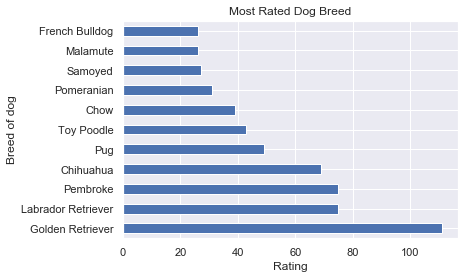

In [1152]:
# scatterplot of dog breeeds
dog_breed = We_Rate_Dogs_Analysis.groupby('breed').filter(lambda x: len(x) >= 25)
dog_breed['breed'].value_counts().plot(kind = 'barh')
plt.title('Most Rated Dog Breed')
plt.xlabel('Rating')
plt.ylabel('Breed of dog');

The most popular dog breed is a golden retriever (111), while labrador retriever and Pembroke are equally in the second place (75), then comes Chihuahua in the third place (69).

In [1148]:
# view the dog name with the highest rating
We_Rate_Dogs_Analysis.loc[We_Rate_Dogs_Analysis['rating'].idxmax()]

tweet_id          810984652412424192                                                                                                                                                       
timestamp         2016-12-19 23:06:23+00:00                                                                                                                                                
name              Sam                                                                                                                                                                      
stage             NaN                                                                                                                                                                      
breed             Golden Retriever                                                                                                                                                         
rating            3.42857                                   

In [1150]:
# Display the image of the most rated dog
from IPython.display import Image 
Image(url = '  https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg')

In [1151]:
# view the dog name with the lowest rating
We_Rate_Dogs_Analysis.loc[We_Rate_Dogs_Analysis['rating'].idxmin()]

tweet_id          678424312106393600                                                                                                                          
timestamp         2015-12-20 03:58:55+00:00                                                                                                                   
name              Crystal                                                                                                                                     
stage             NaN                                                                                                                                         
breed             Maltese Dog                                                                                                                                 
rating            0.2                                                                                                                                         
confidence        0.759945                    

In [1153]:
# Display the image of the lowest rated dog
from IPython.display import Image 
Image(url = '   https://pbs.twimg.com/media/CWo_T8gW4AAgJNo.jpg')

### 2. Most frequent Dog stages:

In [1091]:
We_Rate_Dogs_Analysis['stage'].value_counts()

pupper          245
doggo           83 
puppo           29 
doggopupper     12 
floofer         9  
doggopuppo      1  
doggofloofer    1  
Name: stage, dtype: int64

Text(0.5, 1.0, 'The Distribution of Dog Stages')

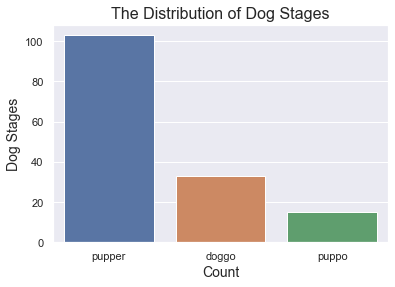

In [1163]:
sorted_stage = We_Rate_Dogs_Analysis['stage'].value_counts().head(3).index
sns.set(style="darkgrid")
sns.countplot(data = We_Rate_Dogs_Analysis, x = 'stage', order = sorted_stage, orient = 'h')
plt.xticks(rotation = 360)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Dog Stages', fontsize=14)
plt.title('The Distribution of Dog Stages',fontsize=16)

Pupper is the most frequent reported dog stage (245), followed by doggo (83), puppo (29) and floofer (9).

### 3. Relationship between the number of retweet and favorite count:

In [1154]:
# create the function of correlation coefficient 
def correlation_coeff(x,y):
    std_x = (x-x.mean())/x.std(ddof=0)
    std_y = (y-y.mean())/y.std(ddof=0)
    return(std_x*std_y).mean()

In [1155]:
# correlation between retweet_count and favorite count
correlation_coeff( We_Rate_Dogs_Analysis['retweet_count'],  We_Rate_Dogs_Analysis['favorite_count'])

0.8051309667070433

The coefficient of correlation between the number of retweet and favorite count is positive and it is around 0.85 which means that a dog breed with the highest retweet tends to have higher favorite account.

C:\Users\Pattu\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


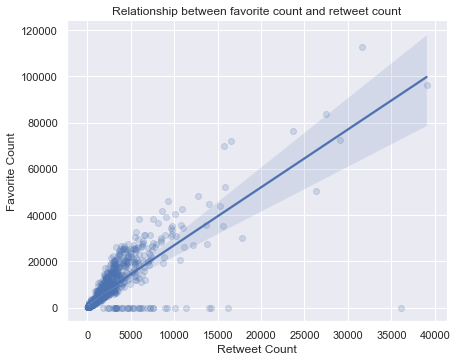

In [1156]:
# Plot scatterplot of retweet vs favorite count
sns.lmplot(x="retweet_count", y="favorite_count", data= We_Rate_Dogs_Analysis, size = 5, aspect=1.3, scatter_kws={'alpha':1/5})
plt.title('Relationship between favorite count and retweet count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

### 4. Retweets and favorites over time:

In [1157]:
# Set the index to be the timestamp so time is displayed properly in plots
We_Rate_Dogs_Analysis.timestamp = pd.to_datetime(We_Rate_Dogs_Analysis['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

monthly_tweets = We_Rate_Dogs_Analysis.groupby(pd.Grouper(key = 'timestamp', freq = "M")).count().reset_index()
monthly_tweets = monthly_tweets[['timestamp', 'tweet_id']]
monthly_tweets.head()
monthly_tweets.sum()

tweet_id    1267
dtype: int64

In [1158]:
# Set the index to be the timestamp so time is displayed properly in plots
We_Rate_Dogs_Analysis.set_index('timestamp', inplace=True)

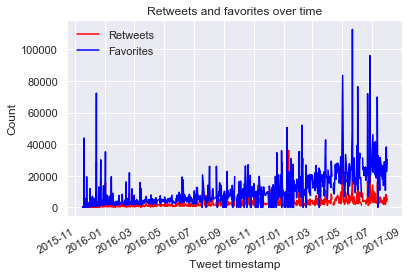

In [1159]:
We_Rate_Dogs_Analysis['retweet_count'].plot(color = 'red', label='Retweets')
We_Rate_Dogs_Analysis['favorite_count'].plot(color = 'blue', label='Favorites')
plt.style.use('seaborn-darkgrid')
plt.legend(loc='upper left')
plt.xlabel('Tweet timestamp')
plt.ylabel('Count')
plt.title('Retweets and favorites over time')
plt.savefig('retweets_favorites.png')
plt.show()

It worth noting that the he highest ratings do not receive the most retweets.

### References:

WeRateDogs Twitter: https://twitter.com/dog_rates?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor

Pandas Documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.cat.html

In [ ]:
https://stackoverflow.com/questions/47612822/how-to-create-pandas-dataframe-from-twitter-search-api

30 Days of Python - Day 21 - Twitter API with Tweepy - Python TUTORIAL: https://www.youtube.com/watch?v=dvAurfBB6Jk